# Session analysis

In [1]:
import pandas as pd

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg

In [2]:
import matplotlib
matplotlib.use('Agg')

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [3]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

In [4]:
data_dir = "/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/"
lsl_dir = "../mna/LSLPresets/"
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
input_path = data_dir + onlyfiles[4] # pick a random file
print(f"input_path {input_path}")
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
with open(input_path, 'rb') as handle:
    rns_data = pickle.load(handle)
    
## Add metadata to data

for key in rns_data.keys():
    rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

input_path /Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/08_08_2022_10_33_49-Exp_adadrive-Sbj_9-Ssn_3.dats.pkl


# 2. Create new events (trial start etc.)

In [5]:
event_df = event_data_from_data(rns_data)
event_df['trial_damage'] = event_df.damage.diff().fillna(0)
event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
percent_missing = event_df.notnull().sum() / len(event_df)
summary_statistics = {}
summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
if 'chunk_timestamp' in percent_missing:
    summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
else:
    summary_statistics['chunk_success_rate'] = 0

# temporary fix for pilot phase where we had some incomplete data
if 'block_condition' not in event_df:
    event_df['block_condition'] = 'practice'
    event_df.loc[5:,'block_condition'] = 'voice'

event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                      value=[1, 2, None])

<AxesSubplot:ylabel='Count'>

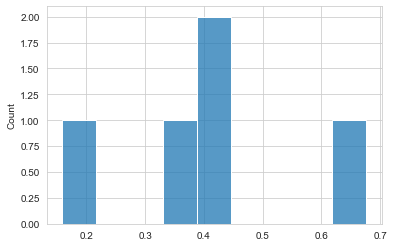

In [10]:
event_df

# 3. ECG Data Processing

In [6]:
post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

# 4. Eye Tracking Processing

In [7]:
post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,plot_frequency=20, plot_eye_snippet=40)

Computed velocity exceeds threshold. Inappropriate filter setup? [2087.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2566.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1798.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1811.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1711.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1991.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1886.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1862.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1512.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1002.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1054.9 > 1000.0 deg/s]
Computed velocity exc

# 5. EEG

In [7]:
post_processed_event_df, epochs, events, event_dict, info, reject_log, ica = process_session_eeg(rns_data, post_processed_event_df,
                                                                    event_column='spoken_difficulty_encoded', run_autoreject=True, run_ica=True)

Creating RawArray with float64 data, n_channels=89, n_times=2725394
    Range : 0 ... 2725393 =      0.000 ...  1330.758 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

# 5. Motor

In [14]:
post_processed_event_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)


# 5. Save

In [19]:
post_processed_event_df.to_csv(f"../output/ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")

### Interactive PivotTable

In [20]:
from pivottablejs import pivot_ui
pivot_ui(post_processed_event_df, outfile_path=f"../output/post_processed_event_df.html");